# Dimensionality Reduction Methods

Quite often it happens that there are a lot of features. We wish to reduce their number so that the problem is still well solvable. In this notebook we will look at several different ways to reduce dimensionality.

> "To deal with hyper-planes in a 14 dimensional space, visualize a 3D space and say 'fourteen' very loudly. Everyone does it." — Geoffrey Hinton

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# 1. Feature selection

The simplest way to prepare features is to select them. There are many different feature selection strategies.


- __One-dimensional strategies:__ We consider how strongly the features are related to the target using different metrics, leaving only the most related ones
- __Greedy Feature Selection Methods:__ A family of algorithms that iterate through different subsets of features and select the one that provides the best performance for a particular machine learning model
- __Model-based feature selection.__ Let models to determine the feature importance

We will select features based on their correlation with the target feature and compare the results with the original ones.

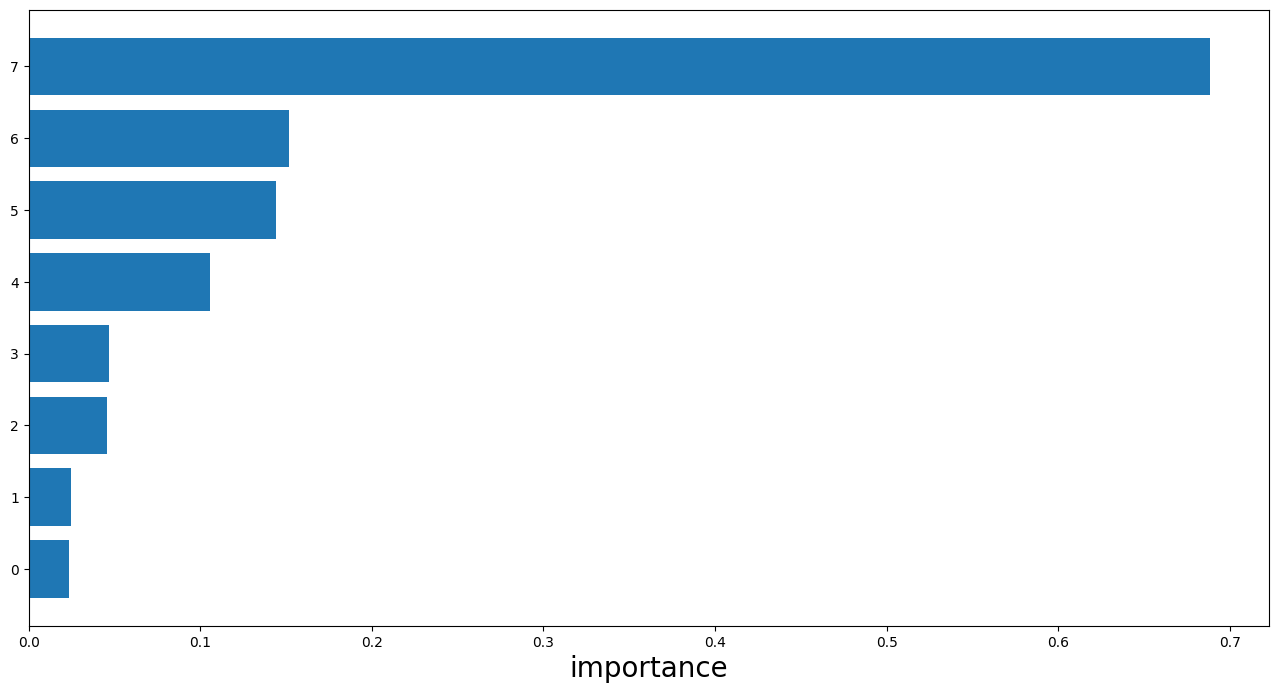

In [2]:
from scipy.stats import pearsonr

from sklearn.datasets import fetch_california_housing
ds = fetch_california_housing()

X, y = ds.data, ds.target
indexes = np.arange(len(y))
np.random.seed(52342)
np.random.shuffle(indexes)
X = X[indexes, :]
y = y[indexes]

features_ind = np.arange(X.shape[1])
corrs = np.abs([pearsonr(X[:, i], y)[0] for i in features_ind])
importances_sort = np.argsort(corrs)
fig = plt.figure(figsize=(16,8))
plt.barh(features_ind, corrs[importances_sort])
plt.xlabel('importance', fontsize=20)
X = X[:, importances_sort]

In [3]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

features_counts = np.arange(X.shape[1])

def scores_by_features_count(reg):
    scores = []
    for features_part in features_counts:
        X_part = X[:,importances_sort[features_part:]]
        scores.append(cross_val_score(reg, X_part, y).mean())
    return scores

linreg_scores = scores_by_features_count(LinearRegression())
rf_scores = scores_by_features_count(RandomForestRegressor(n_estimators=100, max_depth=3))

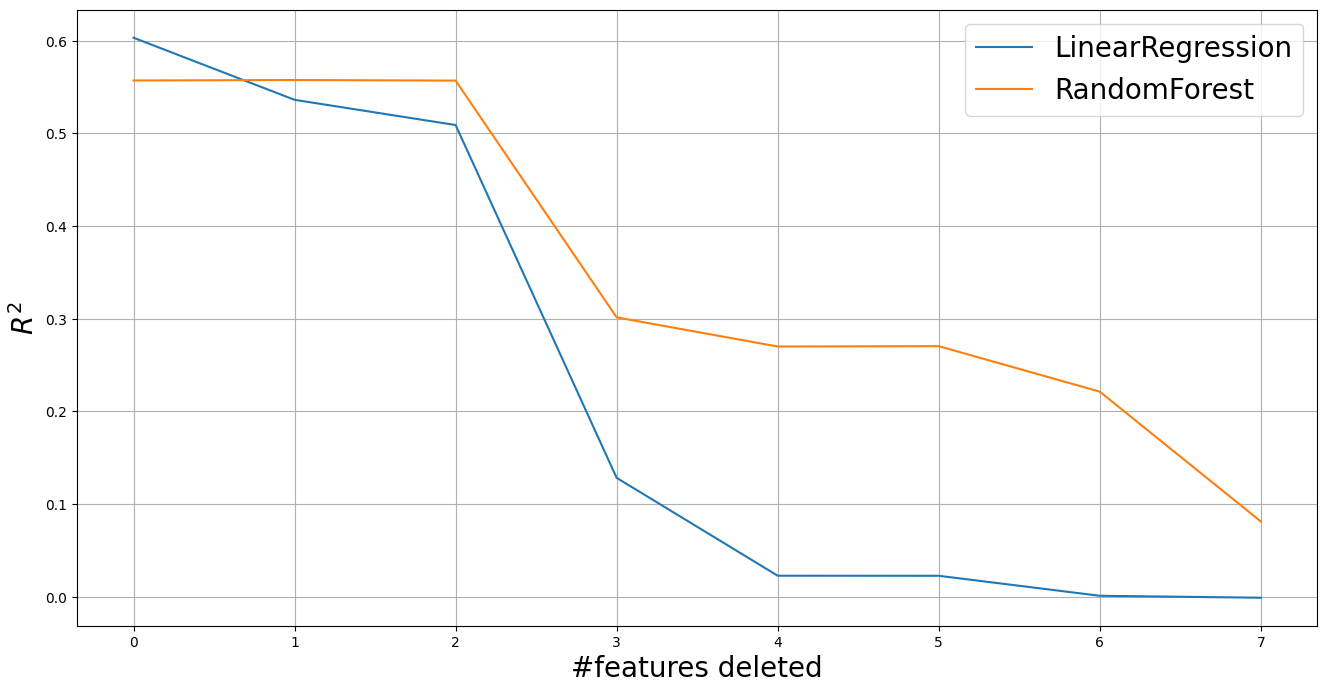

In [4]:
plt.figure(figsize=(16,8))

plt.plot(features_counts, linreg_scores, label='LinearRegression')
plt.plot(features_counts, rf_scores, label='RandomForest')
plt.legend(loc='best', fontsize=20)
plt.xlabel('#features deleted', fontsize=20)
plt.ylabel('$R^2$', fontsize=20)
plt.grid()

In general, if we want to slightly reduce resource consumption by sacrificing some quality, it is clear that this can be done.

# 2. Principal Component Analysis, PCA

Feature preparation through feature selection often produces poor results, and in some situations this approach is practically useless. For example, if we are working with images whose features are the brightness of the pixels, it is impossible to select a small subset of pixels that gives good information about the contents of the image. Therefore, the features need to be combined somehow.

__Principal Component Analysis__ &mdash; is one of the most intuitively simple and frequently used methods for reducing the dimensionality of data and projecting it onto an orthogonal feature subspace. Within the method, two important simplifications of the problem are made:

1. target variable is ignored;
2. a linear combination of features is constructed.

P. 1 seems rather strange at first glance, but in practice it is usually not so bad. This is due to the fact that often the data is arranged in such a way that it has some kind of internal structure in a lower-dimensional space that is in no way related to the target variable. Therefore, optimal features can be constructed without looking at the answer.

P. 2 also simplifies the problem, but later we will learn how to get rid of it.

### Theory

Let us briefly recall what this method does (for details, see the lecture).

Let $X$ be a matrix of objects-features, **with a zero mean of each feature**, and $w$ be some unit vector. Then $Xw$ specifies the magnitude of the projections of all objects onto this vector. Next, we look for the vector that preserves the greatest dispersion of the resulting projections

$$
\max_{w: \|w\|=1} \| Xw \|^2 =  \max_{w: \|w\|=1} w^T X^T X w
$$

The fit vector is then equal to the eigenvector of the matrix $X^T X$ (which is equal to covariance matrix up to $\frac{1}{N}$ scaling factor and under condition of means being equal to zero) with the largest eigenvalue. After this, the entire space is projected onto the orthogonal complement of the vector $w$ and the process is repeated: we project all the given objects onto principle components using dot product

## 2.1 PCA in 2-dim space

First, let's look at the PCA method in the plane to better understand how it works. Let's specifically try to make one of the features more significant and check if PCA detects it. Let's generate a sample from a bivariate normal distribution with zero expected value.

In [5]:
np.random.seed(314512)

data_synth_1 = np.random.multivariate_normal(
    mean=[0, 0],
    cov=[[4, 0],
         [0, 1]],
    size=1000
)

Now let's plot the sample points on the plane and apply PCA to them to find the principal components. As a result of PCA from sklearn, `dec.components_` will contain the main normalized directions, and `dec.explained_variance_` will contain the variance that each component explains. Let's depict these directions on our plot and multiply them by the dispersion to visually display their significance.

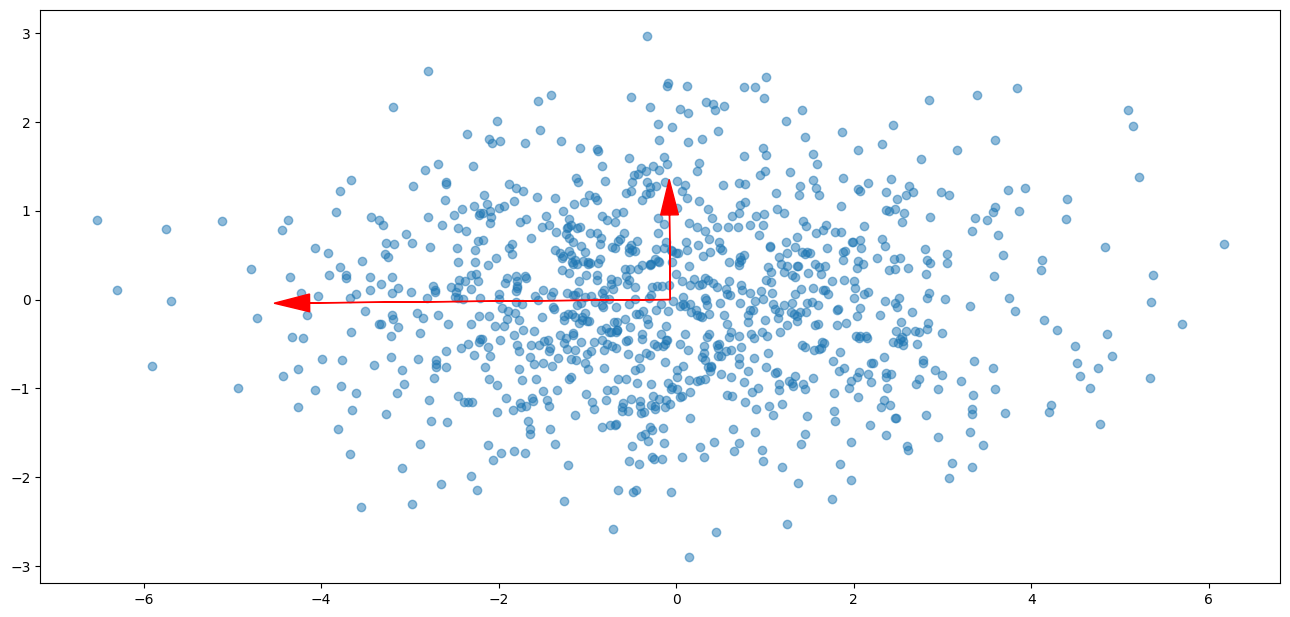

In [6]:
from sklearn.decomposition import PCA

def PCA_show(dataset):
    plt.scatter(*zip(*dataset), alpha=0.5)

    dec = PCA()
    dec.fit(dataset)
    ax = plt.gca()
    for comp_ind in range(dec.components_.shape[0]):
        component = dec.components_[comp_ind, :]
        var = dec.explained_variance_[comp_ind]
        start, end = dec.mean_, component * var
        ax.arrow(start[0], start[1], end[0], end[1],
                 head_width=0.2, head_length=0.4, fc='r', ec='r')

    ax.set_aspect('equal', adjustable='box')

plt.figure(figsize=(16, 8))
PCA_show(data_synth_1)

We see that PCA found everything correctly. But this, of course, could be done simply by calculating the variance of each attribute. Let's rotate our data by some fixed angle and check that this does not change anything for PCA.

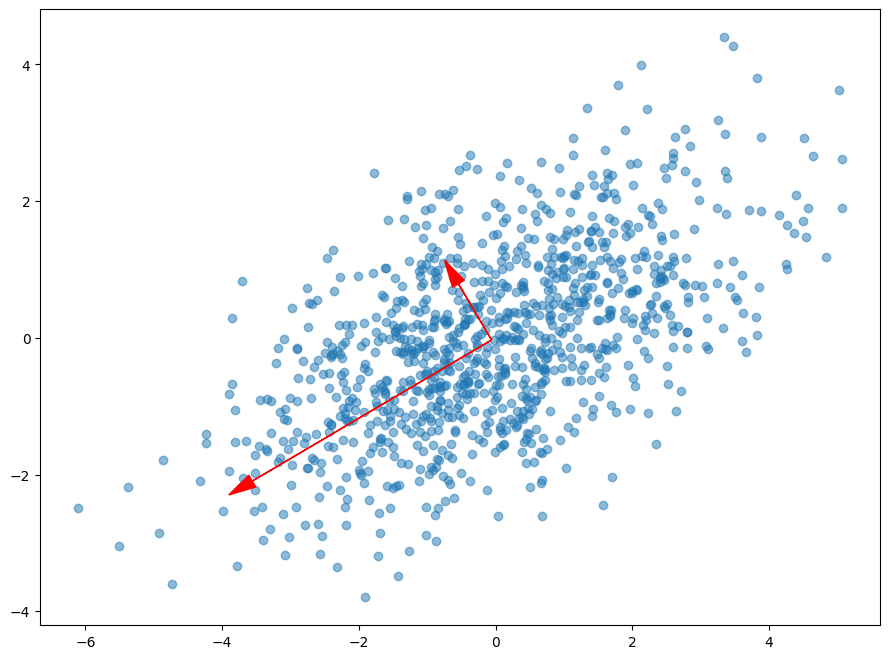

In [7]:
angle = np.pi / 6
rotate = np.array([
        [np.cos(angle), - np.sin(angle)],
        [np.sin(angle), np.cos(angle)],
    ])
data_synth_2 = rotate.dot(data_synth_1.T).T

plt.figure(figsize=(16, 8))
PCA_show(data_synth_2)

Below are a couple of examples where PCA did not work so well (in the sense that the directions do not set very good features).

**Exercise:** explain why this happened.

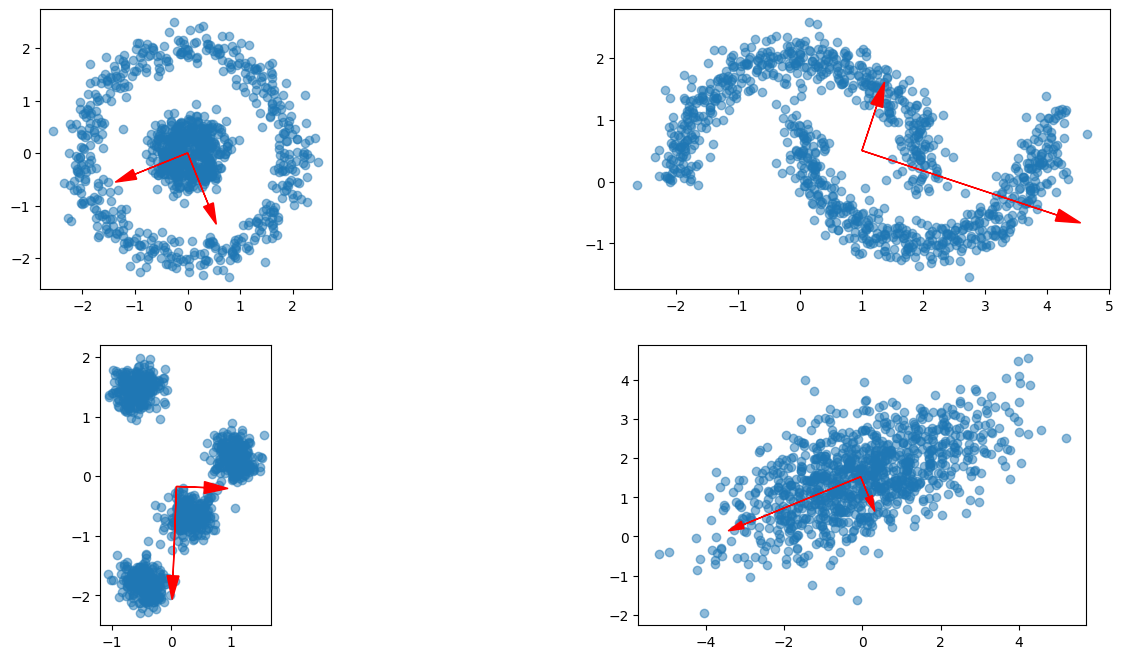

In [8]:
from sklearn.datasets import make_circles, make_moons, make_blobs

np.random.seed(54242)

data_synth_bad = [
    make_circles(n_samples=1000, factor=0.2, noise=0.1)[0]*2,
    make_moons(n_samples=1000, noise=0.1)[0]*2,
    make_blobs(n_samples=1000, n_features=2, centers=4)[0]/5,
    np.random.multivariate_normal(
        mean=[0, 1.5],
        cov=[[3, 1],
             [1, 1]],
        size=1000),
]
plt.figure(figsize=(16,8))
rows, cols = 2, 2
for i, data in enumerate(data_synth_bad):
    plt.subplot(rows, cols, i + 1)
    PCA_show(data)

## 2.2 Human faces

Let's consider a dataset with photographs of people's faces and apply PCA to its features. Below are examples of faces from the database, and the last picture is the "average face".

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


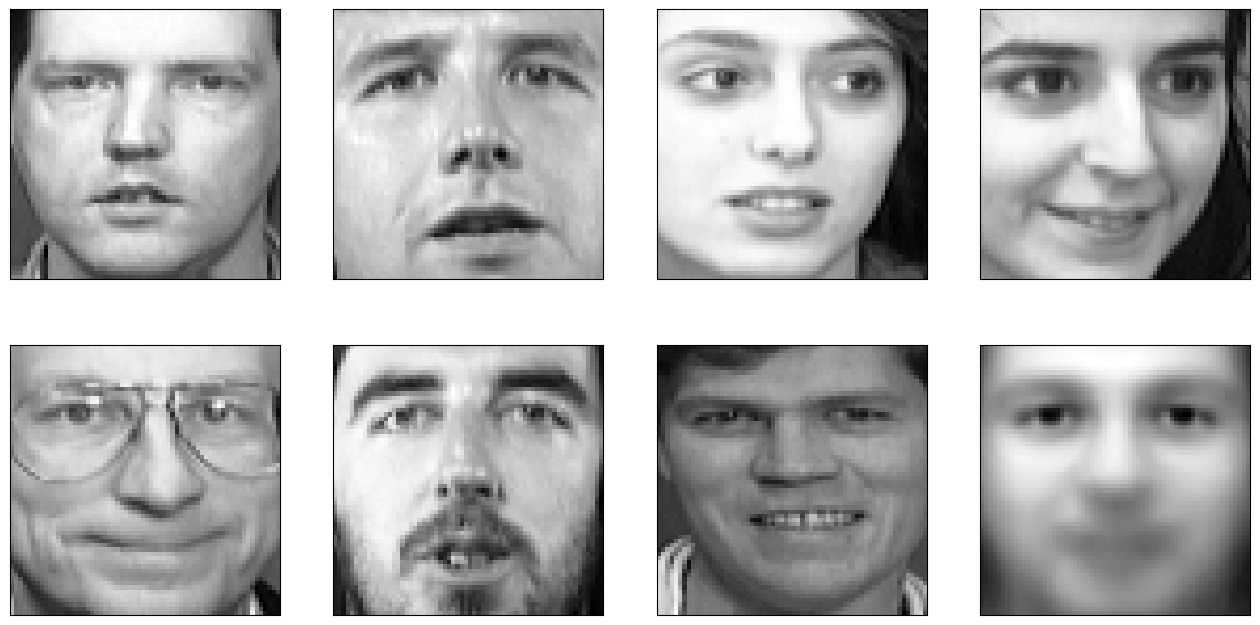

In [9]:
from sklearn.datasets import fetch_olivetti_faces

faces = fetch_olivetti_faces(shuffle=True, random_state=432542)
faces_images = faces.data
faces_ids = faces.target
image_shape = (64, 64)

mean_face = faces_images.mean(axis=0)

plt.figure(figsize=(16, 8))
rows, cols = 2, 4
n_samples = rows * cols
for i in range(n_samples - 1):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(faces_images[i, :].reshape(image_shape), interpolation='none',
               cmap='gray')
    plt.xticks(())
    plt.yticks(())

plt.subplot(rows, cols, n_samples)
plt.imshow(mean_face.reshape(image_shape), interpolation='none',
           cmap='gray')
plt.xticks(())
_ = plt.yticks(())

Now let's find the main components

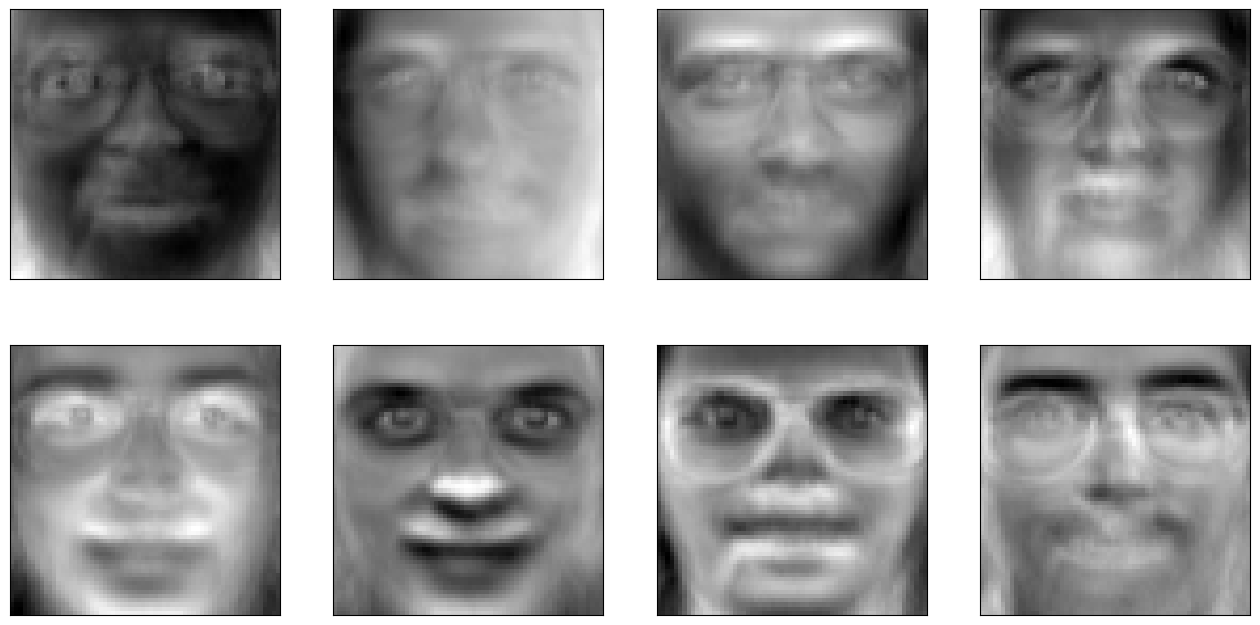

In [10]:
model_pca = PCA()
faces_images -= mean_face  # normalized the data to zero mean
model_pca.fit(faces_images)

plt.figure(figsize=(16, 8))
rows, cols = 2, 4
n_samples = rows * cols
for i in range(n_samples):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(model_pca.components_[i, :].reshape(image_shape), interpolation='none', cmap='gray')
    plt.xticks(())
    plt.yticks(())

Looks scary  but is there any benefit?

- Firstly, new features provide higher classification quality.

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

gscv_rf = GridSearchCV(
    RandomForestClassifier(),
    {'n_estimators': [100, 200, 500, 800], 'max_depth': [2, 3, 4, 5]}, cv=5
)

In [ ]:
%%time
gscv_rf.fit(faces_images, faces_ids)
print(gscv_rf.best_score_)

In [ ]:
%%time
gscv_rf.fit(model_pca.transform(faces_images)[:,:100], faces_ids)
print(gscv_rf.best_score_)

In practice, you can select enough principal components to leave $90\%$ of variance in the original data. In this case, it is enough to select about $60$ of principal components, that is, reduce the dimension from $4096$ to $60$.

In [ ]:
faces_images.shape

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(np.cumsum(model_pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 63)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(21, c='b')
plt.axhline(0.9, c='r')
plt.show();

 - Secondly, they can be used for compressed data storage. To do this, objects are transformed into a new space, and the most insignificant features are thrown out of it. Below are the results of compression by 20 times.

In [ ]:
base_size = image_shape[0] * image_shape[1]

def compress_and_show(compress_ratio):
    model_pca = PCA(n_components=int(base_size * compress_ratio))
    model_pca.fit(faces_images)

    faces_compressed = model_pca.transform(faces_images)

    # обратное преобразование
    faces_restored = model_pca.inverse_transform(faces_compressed) + mean_face

    plt.figure(figsize=(16, 8))
    rows, cols = 2, 4
    n_samples = rows * cols
    for i in range(n_samples):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(faces_restored[i, :].reshape(image_shape), interpolation='none',
                   cmap='gray')
        plt.xticks(())
        plt.yticks(())

compress_and_show(0.05)

And even when compressed 50 times, faces remain recognizable.

In [ ]:
compress_and_show(0.02)

## 2.3 PCA for the rivers chemical composition visualization

Let's look at another example of using the principal component method. We will work with a subset of [a dataset about rivers chemical composition](http://data.europa.eu/euodp/en/data/dataset/data_waterbase-rivers-10). 

In [ ]:
!wget https://github.com/FUlyankin/Intro_to_DS/raw/master/data/water_dataset

In [ ]:
import pickle
index_list, feature_list, data_matrix = pickle.load(open('water_dataset', 'rb'))

* `index_list` - list of rivers' ids that were selected for the task
* `feature_list` - list of characteristics (they look like `year SPACE indicator`)
* `data_matrix` - the data itself (rows correspond to rivers from `index_list` and columns correspond to features from `feature_list`)

Let's try to do PCA, visualize the data in the space of the first two components and interpret the first principal components.

In [ ]:
X = data_matrix.copy()
X.shape

In [ ]:
from sklearn.decomposition import PCA

model_pca = PCA(10) # оставим 10 компонент
X_pca = model_pca.fit_transform(X)

plt.scatter(X_pca[:,0], X_pca[:,1]);

Direct application of PCA to the data did not give good results.

- Recall that PCA attempts to extract principal components by maximizing variance. The variance is sensitive to outliers, which means that the principal component method is sensitive to them.
- Apparently the data has different units of measurement, which means the spread is not comparable. The PCA is confused.

In [ ]:
plt.hist(X.max(axis=0), bins=30,log=True);

Let's cut outliers at the $99\%$ quantile and then standardize the data.

In [ ]:
replace = np.percentile(X, 99, axis=0)
for i in range(X.shape[1]):
    X[:,i][X[:,i] > replace[i]] = replace[i]

In [ ]:
plt.hist(X.max(axis=0), bins=30,log=True);

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scal = scaler.fit_transform(X)

In [ ]:
model_pca = PCA(10)
X_pca = model_pca.fit_transform(X_scal)

plt.scatter(X_pca[:,0], X_pca[:,1]);

Visualization has become better. To understand the physical meaning of the first signs, let's look at which columns they are formed from.

In [ ]:
sorted(list(zip(feature_list, np.abs(model_pca.components_[0]))), key = lambda w : w[1], reverse=True)[:20]

In [ ]:
sorted(list(zip(feature_list, np.abs(model_pca.components_[1]))), key = lambda w : w[1], reverse=True)[:20]

In [ ]:
sorted(list(zip(feature_list, np.abs(model_pca.components_[3]))), key = lambda w : w[1], reverse=True)[:20]

## 2.4 Kernelized PCA

Since PCA actually works not with the original features, but with their covariance matrix, an arbitrary kernel $K(x_i, x_j)$ can be used to calculate it instead of the scalar product $\langle x_i, x_j \rangle$. This will correspond to a transition to another space. The only problem is that it is not clear how to select a kernel.

Below are examples of objects in the original space (similar groups are indicated in the same color for clarity), and the result of their transformation into new spaces (for different kernels). If the results are linearly separable then it means we have chosen a suitable kernel.

In [ ]:
from sklearn.decomposition import KernelPCA

def KPCA_show(X, y):
    reds = y == 0
    blues = y == 1

    plt.figure(figsize=(8, 8))
    rows, cols = 2, 2
    plt.subplot(rows, cols, 1)
    plt.scatter(X[reds, 0], X[reds, 1], alpha=0.5, c='r')
    plt.scatter(X[blues, 0], X[blues, 1], alpha=0.5, c='b')
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')

    kernels_params = [
        dict(kernel='rbf', gamma=10),
        dict(kernel='poly', gamma=10),
        dict(kernel='cosine', gamma=10),
    ]

    for i, p in enumerate(kernels_params):
        dec = KernelPCA(**p)
        X_transformed = dec.fit_transform(X)

        plt.subplot(rows, cols, i + 2)
        plt.scatter(X_transformed[reds, 0], X_transformed[reds, 1], alpha=0.5, c='r')
        plt.scatter(X_transformed[blues, 0], X_transformed[blues, 1], alpha=0.5, c='b')
        ax = plt.gca()
        ax.set_aspect('equal', adjustable='box')

np.random.seed(54242)
KPCA_show(*make_circles(n_samples=1000, factor=0.2, noise=0.1))

In [ ]:
np.random.seed(54242)
KPCA_show(*make_moons(n_samples=1000, noise=0.1))

# 3. How to calculate PCA? Singular Values Decomposition (SVD)

$X^TX$ calculation is complex and highly depends on both objects' and features' sizes. We need to find a way to make it easier. And here's a way: SVD with efficient implementations. 

At first, let's remember what SVD is. We have a matrix which we we'll be thinking of as a linear transformation, i.e., if we draw 2D square figure on a plane, and draw a straight line through the square, the straight line will be preserved after the linear transformation is applied.

<img src='https://gregorygundersen.com/image/svd/nonlinear.png' width='90%'>

So it means, if we apply a linear transformation to some square $x$, it will either be stretched or compressed along it's sides, rotated, reflected or even squeezed.

<img src='https://gregorygundersen.com/image/svd/transformations.png' width='90%'>

It turns out that the latter may be avoided if we rotate our square before a transformation.

<img src='https://gregorygundersen.com/image/svd/essence.png' width='90%'>

And therefore, if we take appropriately rotated vectors $V$, our transformation will be as simple as multiplication by the diagonal matrix $\Sigma$ and the result will be provided in terms of $U$ vectors. These vectors are actually the eigenvectors of $X^TX$ and $XX^T$ matricies respectively.
  
<img src='https://gregorygundersen.com/image/svd/notation.png' width='90%'>

More about PCA is at [Singular Value Decomposition as Simply as Possible](https://gregorygundersen.com/blog/2018/12/10/svd/)

## SVD and PCA

Actually, the first $n$ eigenvectors of both matricies $X^TX$ and $XX^T$ explain the same amount of variance so they are both good for PCA algorithm.

It turns out it is possible to avoid calculating every component of SVD and instead we only wish to calulacte a single singular vector. There exists numerous of approaches and sklearn uses [LAPACK implementation](https://en.wikipedia.org/wiki/LAPACK) as well as [randomized truncated SVD](https://arxiv.org/pdf/0909.4061.pdf)

# 4. TSNE (t-distributed Stohastic Neighbor Embedding)

Geoffrey Hinton not only spoke the epigraph to this notebook, but together with his graduate student, in 2008, he came up with [a new method in data visualization.](https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf) The main idea of the method is to search for a mapping from a multidimensional feature space to a plane (or in 3D, but almost always 2D), so that points that were far from each other on the plane also turn out to be distant, and close points are also displayed on loved ones. That is, neighbor embedding is a kind of search for a new data representation that preserves the neighborhood.

Let's try to take data about handwritten digits and visualize them using PCA.

In [ ]:
from sklearn.datasets import load_digits
digits = load_digits()

X = digits.data
y = digits.target

plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[i,:].reshape([8,8]), cmap='gray');

In [ ]:
X.shape

It turns out that the dimension of the feature space is 64. But let’s reduce the dimension to just 2 and see that even by eye the handwritten numbers are quite well divided into clusters.

In [ ]:
model_pca = PCA(n_components=2)
X_reduced = model_pca.fit_transform(X)

plt.figure(figsize=(12,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y,
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('MNIST. PCA projection');

Let's try to do the same using t-SNE. The picture will turn out better, since PCA has a significant limitation - it finds only linear combinations of the original features (if you do not add some kind of kernel).

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_jobs=4, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(12,10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y,
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))

plt.colorbar()
plt.title('MNIST. t-SNE projection');

The method has a `Perplexity` parameter, which is responsible for how far the points can scatter from each other.

In [ ]:
tsne = TSNE(n_jobs=4, perplexity=2, random_state=42)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(12,10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y,
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))

plt.colorbar()
plt.title('MNIST. t-SNE projection');

The final image can change greatly when `random_state` is changed, this complicates interpretation. In general, you shouldn’t draw far-reaching conclusions from such pictures as you shouldn’t guess from the coffee grounds.

In 2018, another nonlinear dimensionality reduction algorithm was proposed, [UMAP.](https://umap-learn.readthedocs.io/en/latest/) It is similar to TSNE, but is faster and more efficient.

- [Article, RU](https://habr.com/ru/company/io/blog/265089/) "How to choose a dress using the principal component method"
- [Q&A PCA analysis with intuition and examples, RU](https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues)
- [Distillpub about TSNE](https://distill.pub/2016/misread-tsne/)
- [Understanding UMAP](https://pair-code.github.io/understanding-umap/)

In [ ]:
pip install umap-learn

In [ ]:
import umap

In [ ]:
trans = umap.UMAP()
X_umap = trans.fit_transform(X)


In [ ]:
plt.figure(figsize=(12,10))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y,
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))

plt.colorbar()
plt.title('MNIST. UMAP projection');